# Importing Libraries

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
#from skimage import exposure

#### Load the images

In [2]:
image1 = cv2.imread('image6.jpg') # right image
image2 = cv2.imread('image5.jpg') # left image
image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
image1_2 =cv2.hconcat([image2, image1])


error: OpenCV(4.7.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


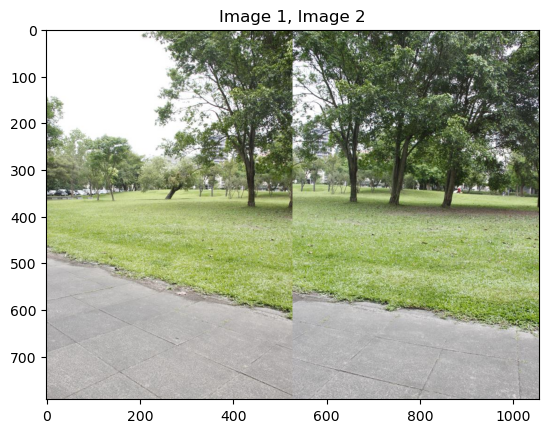

In [3]:

plt.title('Image 1, Image 2')
plt.imshow(image1_2)

### Apply Histogram Matching

In [4]:

# # Convert the images from RGB to LAB color space
# source = cv2.cvtColor(image1, cv2.COLOR_BGR2LAB).astype("float32")
# reference = cv2.cvtColor(image2, cv2.COLOR_BGR2LAB).astype("float32")


In [5]:

# # Split the channels
# source_channels = cv2.split(source)
# reference_channels = cv2.split(reference)

# # Perform histogram matching using skimage.exposure
# matched_channels = []
# for d, s in zip(reference_channels, source_channels):
#     matched_channel = exposure.match_histograms(s, d, multichannel=False)
#     matched_channels.append(matched_channel)

# # Merge the channels
# matched = cv2.merge(matched_channels).astype('uint8')


In [6]:

# Convert back to BGR color space
# matched = cv2.cvtColor(matched, cv2.COLOR_LAB2BGR)


In [7]:
# # Display the images
# plt.figure(figsize=(10, 10))
# plt.subplot(2, 2, 1)
# plt.title('Source')
# plt.imshow(source.astype('uint8'))
# plt.subplot(2, 2, 2)
# plt.title('Reference')
# plt.imshow(reference.astype('uint8'))
# plt.subplot(2, 2, 4)
# plt.title('After Histogram Matching')
# plt.imshow(matched)
# plt.subplot(2, 2, 3)
# plt.title('Before Histogram Matching')
# plt.imshow(image1)
# plt.show()

In [8]:
# image1 = matched

#### Convert images to grayscale (optional but can improve speed and matching)

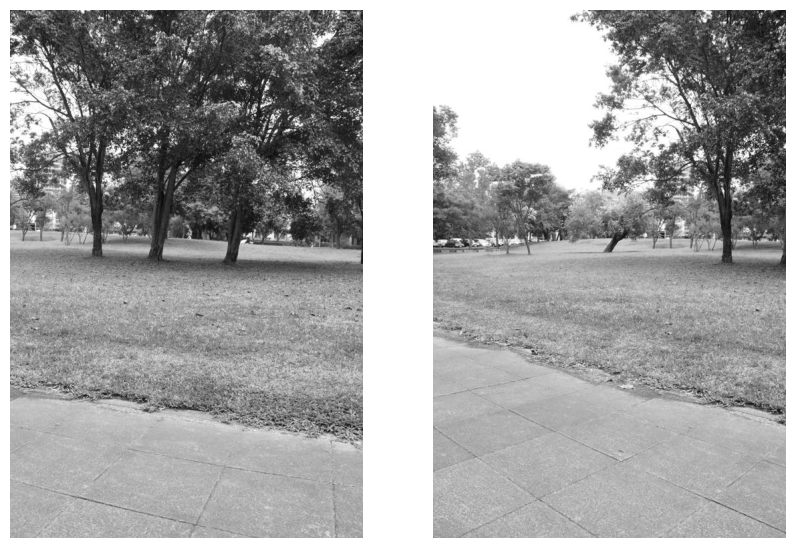

In [9]:
gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.axis('off')
plt.imshow(gray1, cmap='gray')
plt.subplot(1, 2, 2)
plt.axis('off')
plt.imshow(gray2, cmap='gray')
plt.show()

#### Use the ORB (Oriented FAST and Rotated BRIEF) feature detector and descriptor

In [10]:
orb = cv2.ORB_create()

#### Find the keypoints and descriptors with ORB

In [11]:
keypoints1, descriptors1 = orb.detectAndCompute(gray1, None)
keypoints2, descriptors2 = orb.detectAndCompute(gray2, None)

#### Use the Brute-Force matcher to find the best matches

In [12]:

bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(descriptors1, descriptors2)

#### Sort the matches based on their distances


In [13]:
matches = sorted(matches, key=lambda x: x.distance)


In [14]:
# print the size of matches
print(len(matches))

182


#### Show the matching points between the two images based on the distance

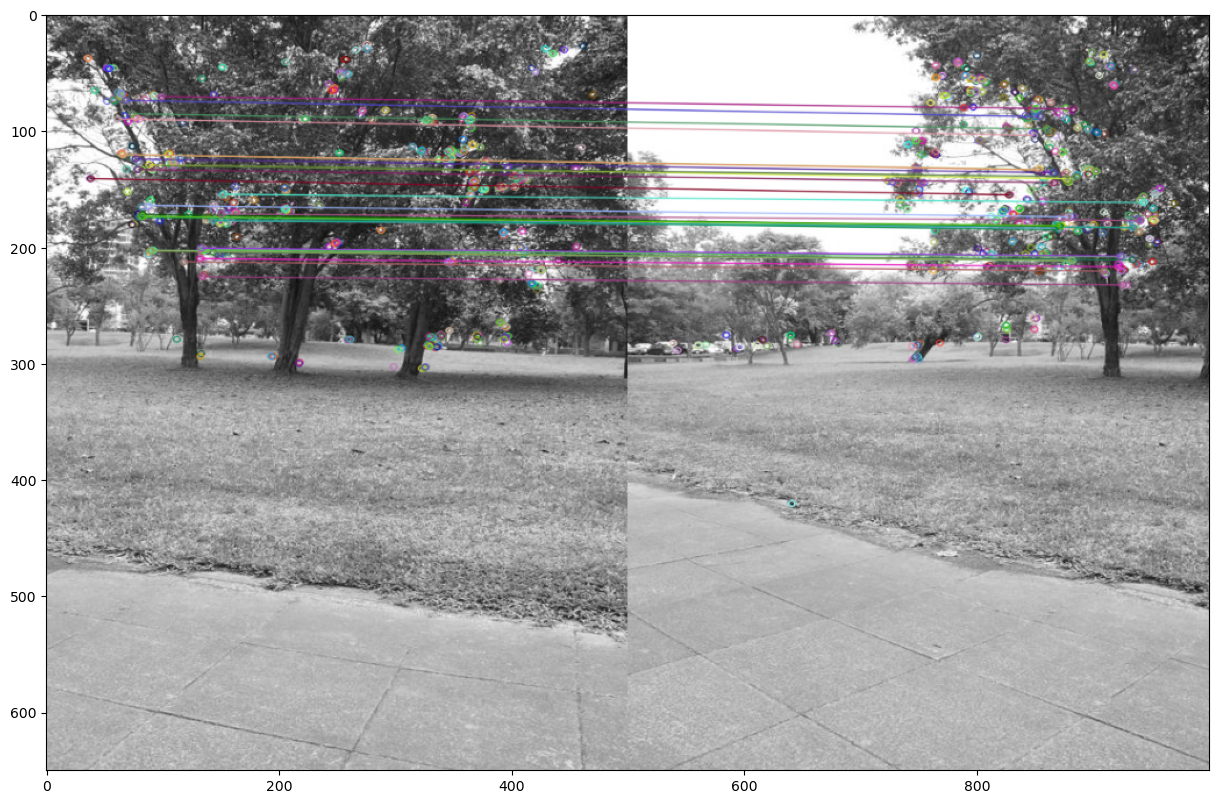

In [15]:
final_img = cv2.drawMatches(gray1, keypoints1, gray2, keypoints2, matches[0:30],None) 
final_img = cv2.resize(final_img, (1000,650)) 

plt.figure(figsize=(15, 15))
plt.imshow(final_img)


#### Extract the matched keypoints

In [16]:
src_points = np.float32([keypoints1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
dst_points = np.float32([keypoints2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)



#### Use the RANSAC algorithm to find a perspective transformation


In [17]:
M, mask = cv2.findHomography(src_points, dst_points, cv2.RANSAC, 5.0)

#### Apply the perspective transformation to stitch the images

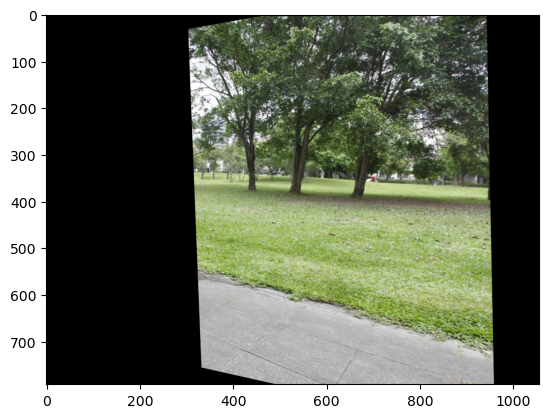

In [18]:
result = cv2.warpPerspective(image1, M, (image1.shape[1] + image2.shape[1], image1.shape[0]))
plt.imshow(result)

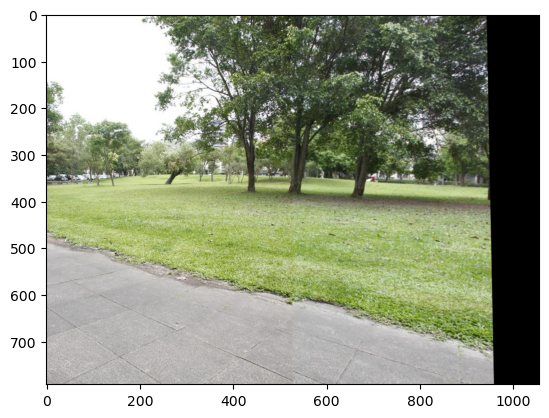

In [19]:
result[:, 0:image2.shape[1]] = image2
plt.imshow(result)

#### Crop the black area from the image

In [20]:
def crop_image(img, tol=0):
    # Turn image to grayscale
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Find the non-zero pixels
    coords = cv2.findNonZero(gray_img)
    
    # Get the bounding rectangle
    x, y, w, h = cv2.boundingRect(coords)
    print(x, y, w, h)
    new_w1, new_w2 = 0,0
    for i in range(1, w):
        if(gray_img[0, w-i] != 0):
            new_w1 = w-i
            break
    for i in range(1, w):
        if(gray_img[h-1, w-i] != 0):
            new_w2 = w-i
            break
    if(new_w1 < new_w2):
        w = new_w1
    else:
        w = new_w2
    # Crop the image
    cropped_img = img[y:y+h, x:x+w]
    
    return cropped_img
cropped_result = crop_image(result)


0 0 960 792


##### Plot the cropped image

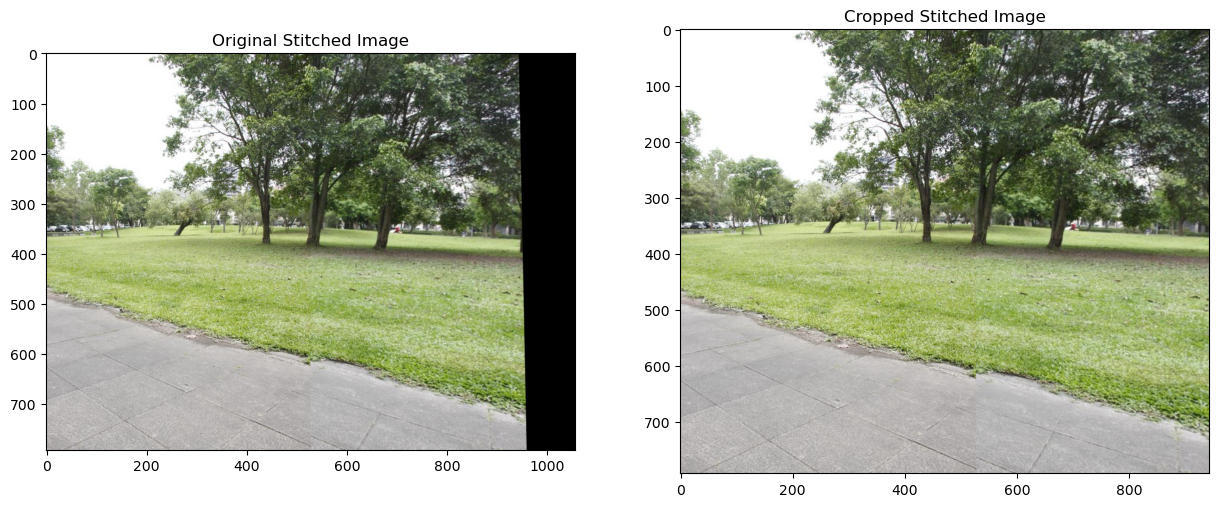

In [21]:
plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 2)
plt.title('Cropped Stitched Image')
plt.imshow(cropped_result)
plt.subplot(1, 2, 1)
plt.title('Original Stitched Image')
plt.imshow(result)

#### Plot the original 2 images + the Result

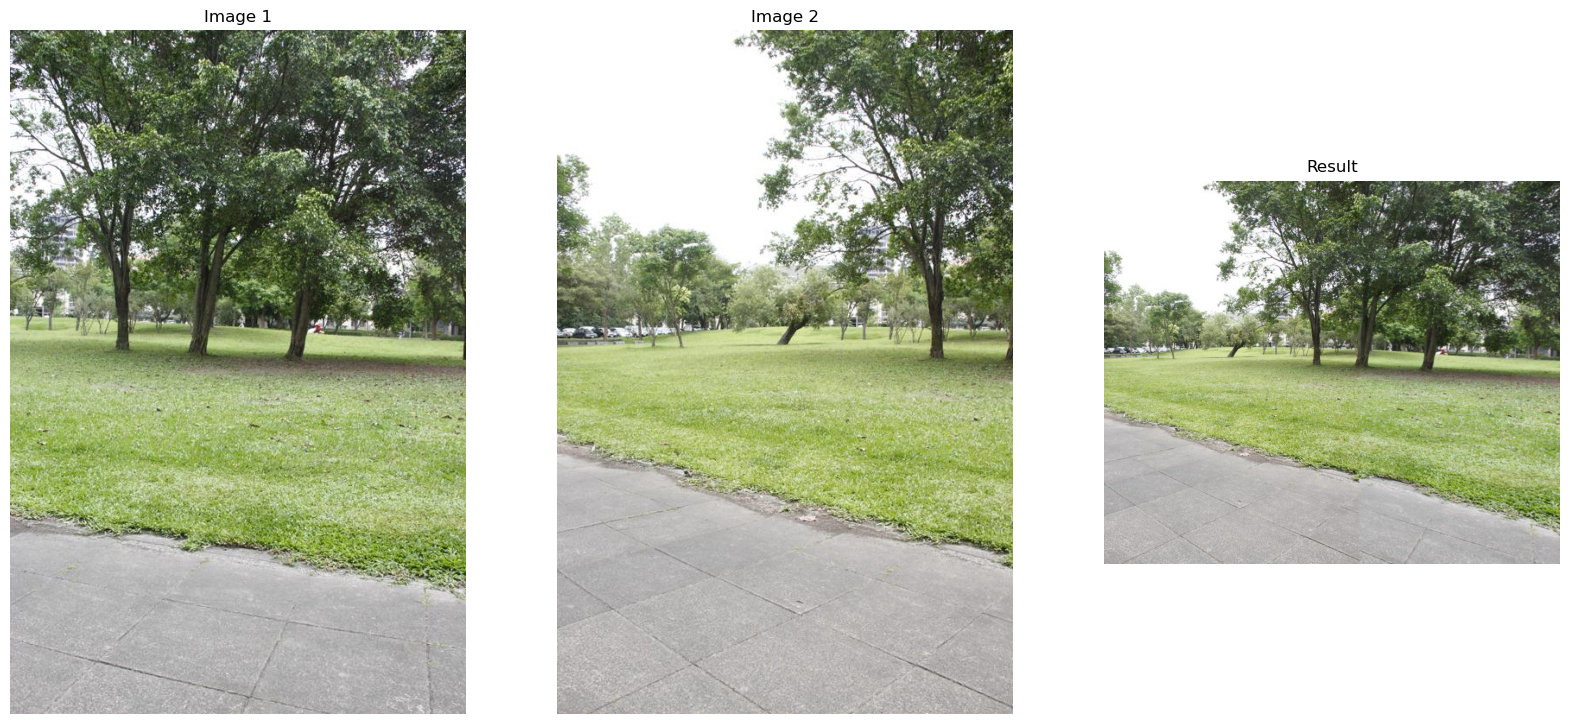

In [22]:
plt.figure(figsize=(20,20))
plt.subplot(1,3,1)
plt.axis('off')
plt.title('Image 1')
plt.imshow(image1)
plt.subplot(1,3,2)
plt.axis('off')
plt.title('Image 2')
plt.imshow(image2)
plt.subplot(1,3,3)
plt.axis('off')
plt.title('Result')
plt.imshow(cropped_result)
plt.show()


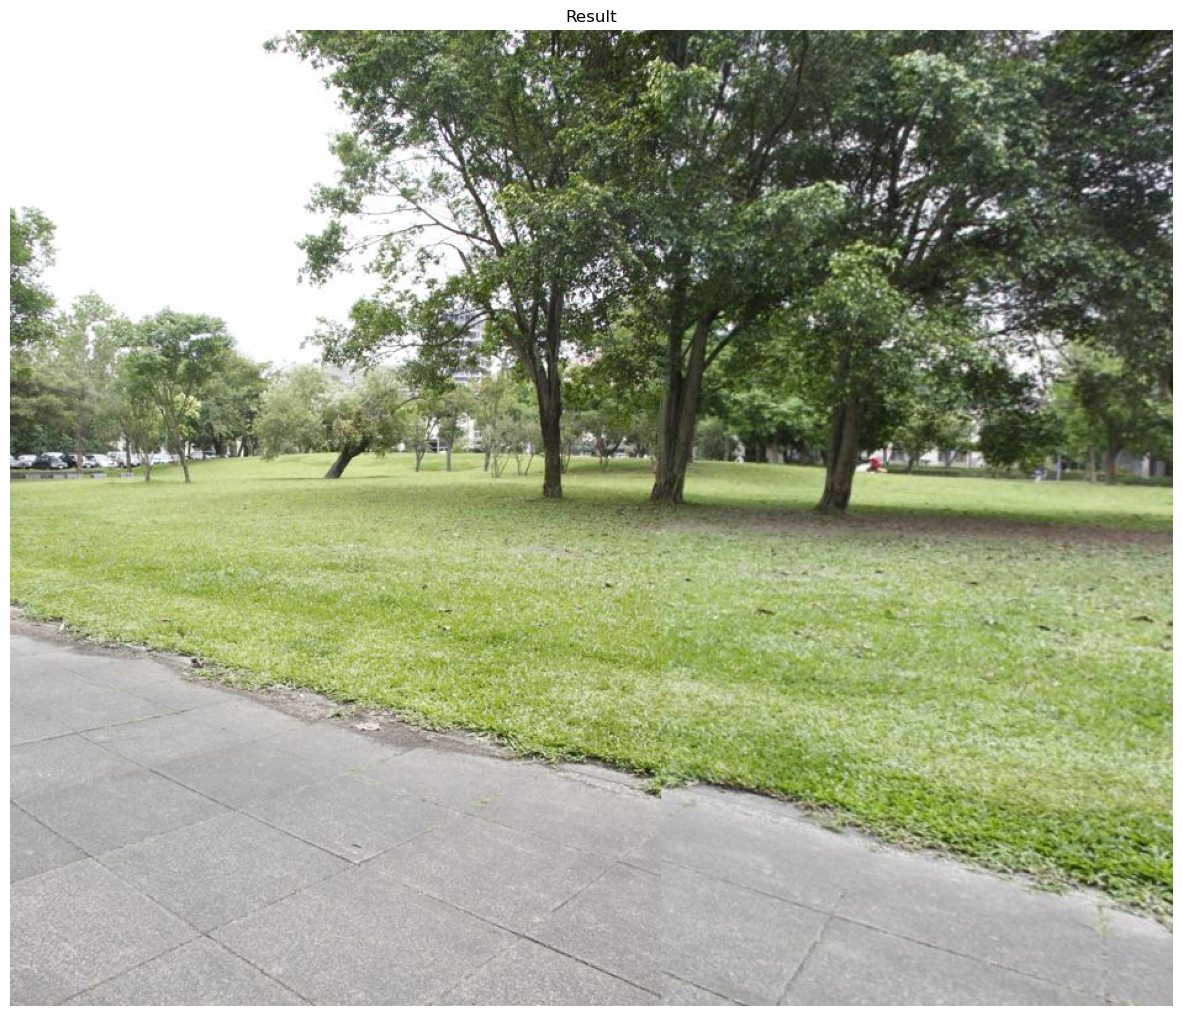

In [23]:
plt.figure(figsize=(15,15))
plt.axis('off')
plt.title('Result')
plt.imshow(cropped_result)


#### Saving the Image

In [24]:
s = cv2.cvtColor(cropped_result, cv2.COLOR_BGR2RGB)
cv2.imwrite("stitchedimg.jpg", s)

True